In [ ]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models

In [ ]:
kaggle_credentials = json.load(open("kaggle.json"))

In [ ]:
os.environ['KAGGLE_USERNAME']=kaggle_credentials["username"]
os.environ['KAGGLE_KEY']=kaggle_credentials["key"]

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

 99% 2.68G/2.70G [00:11<00:00, 269MB/s]
100% 2.70G/2.70G [00:11<00:00, 259MB/s]


In [ ]:
!ls

kaggle.json  new-plant-diseases-dataset.zip  sample_data


In [ ]:
with ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.models import inception_v3
import matplotlib.pyplot as plt

In [ ]:
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import models


In [ ]:
diseases = os.listdir(train_dir)
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

valid_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_dir, transform=train_transforms)
valid_dataset = ImageFolder(valid_dir, transform=valid_transforms)


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)


In [ ]:
model = models.inception_v3(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer for our classification task
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # If the model returns auxiliary outputs, use main outputs for loss calculation
        if isinstance(outputs, tuple):
            outputs, aux_outputs = outputs
            loss = criterion(outputs, labels)
        else:
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # If the model returns auxiliary outputs, use main outputs for loss calculation
            if isinstance(outputs, tuple):
                outputs, aux_outputs = outputs
                loss = criterion(outputs, labels)
            else:
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(valid_dataset)
    val_accuracy = correct_predictions / total_predictions

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {epoch_loss:.4f}, '
          f'Validation Loss: {val_epoch_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/10], Training Loss: 0.3840, Validation Loss: 0.1778, Validation Accuracy: 0.9427
Epoch [2/10], Training Loss: 0.3849, Validation Loss: 0.1606, Validation Accuracy: 0.9488
Epoch [3/10], Training Loss: 0.3892, Validation Loss: 0.1727, Validation Accuracy: 0.9449
Epoch [4/10], Training Loss: 0.3878, Validation Loss: 0.1666, Validation Accuracy: 0.9456
Epoch [5/10], Training Loss: 0.3845, Validation Loss: 0.1718, Validation Accuracy: 0.9446
Epoch [6/10], Training Loss: 0.3900, Validation Loss: 0.1734, Validation Accuracy: 0.9425
Epoch [7/10], Training Loss: 0.3848, Validation Loss: 0.1684, Validation Accuracy: 0.9448
Epoch [8/10], Training Loss: 0.3912, Validation Loss: 0.1626, Validation Accuracy: 0.9478
Epoch [9/10], Training Loss: 0.3804, Validation Loss: 0.1537, Validation Accuracy: 0.9500
Epoch [10/10], Training Loss: 0.3921, Validation Loss: 0.1564, Validation Accuracy: 0.9497


In [ ]:
def to_device(data, device):
    """Move tensor(s) to the specified device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Soybean___

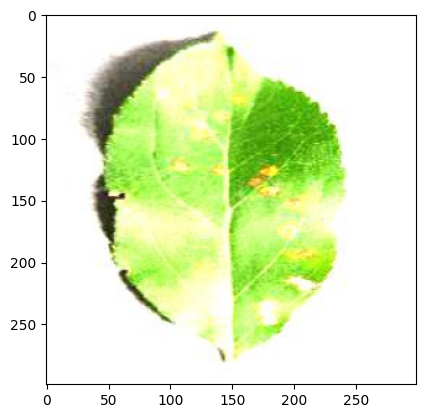

In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the test directory
test_dir = "/content/test"

# Define the transformation for test images
test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to the size required by InceptionV3
    transforms.ToTensor()
])

# Create the ImageFolder dataset for test images
test_dataset = ImageFolder(test_dir, transform=test_transforms)

# Function to predict image label
def predict_image(img, model):
    xb = img.unsqueeze(0)
    xb = xb.to(device)
    preds = model(xb)
    _, pred_labels = torch.max(preds, dim=1)
    return train_dataset.classes[pred_labels.item()]

# Test the predict_image function on the first image
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))

# Predict labels for all test images
for i, (img, label) in enumerate(test_dataset):
    image_filename = os.path.basename(test_dataset.imgs[i][0])
    predicted_label = predict_image(img, model)
    print(f'Label: {image_filename} , Predicted: {predicted_label}')
